# Importing Libraries

In [1]:
import matplotlib.pyplot as plt
import math
import pandas as pd
import numpy as np
import scipy.stats
from tabulate import tabulate
from IPython.display import display, HTML

# Importing Random Variable Generators

In [2]:
import sys
import os

# Getting the path to Parent Directory
root = os.path.abspath(os.path.join(os.path.dirname(__file__), '..')) if '__file__' in globals() \
               else os.path.abspath(os.path.join(os.getcwd(), '..'))

# Adding it to sys.path so Python can find 'scripts'
if root not in sys.path:
    sys.path.append(root)

# Now we can import our classes
from scripts.random_utils import Gamma, Poisson


# Importing Dataset

In [3]:
df = pd.read_csv("../data/processed/trades_2025-10-01_to_2025-10-07_1min.csv")

# Random Variable Generators

# Gamma-Poisson Model

In [4]:
class Gamma_Poisson:
    def __init__(self, alpha, beta, lag, df: pd.DataFrame):
        if alpha <= 0 or beta <= 0:
            raise ValueError("alpha and beta must be > 0")
        if lag <=0:
            raise ValueError("lag must be a Natural number")
            
        self.alpha = alpha
        self.beta = beta
        self.lag = (lag)
        self.df = df
        
        self.params = {"alpha":[alpha], "beta":[beta]}
        self.ppi = {}

    def generate_posterior(self):
        df = self.df
        df = df.sort_values(by="timestamp").reset_index(drop=True)
        array = df["trade_count"].tolist()
        alphas = []
        betas = []
        for i in range(len(array)):
            sum_counts = 0  
            upd_time = 0
            for j in range(max(0, i - self.lag + 1), i):
                sum_counts += array[j]
                upd_time = upd_time + 1

            alphas.append(sum_counts + self.alpha)
            betas.append(self.beta + upd_time)

        self.params["alpha"] = alphas
        self.params["beta"] = betas
    
    def generate_ppi(self, percent):
        ppis = {"lower_bound":[], "upper_bound":[]}
        percent = 1 - percent
        for alpha, beta in zip(self.params["alpha"][0:], self.params["beta"][0:]):
            r = alpha
            p = beta / (beta + 1)

            lb = scipy.stats.nbinom.ppf(percent / 2, r, p)
            ub = scipy.stats.nbinom.ppf(1 - percent / 2, r, p)
            ppis["lower_bound"].append(lb)
            ppis["upper_bound"].append(ub)

        self.ppi[1 - percent] = ppis

# Observed Trade Count Vs Posterior Mean Trade Rate $(\lambda)$

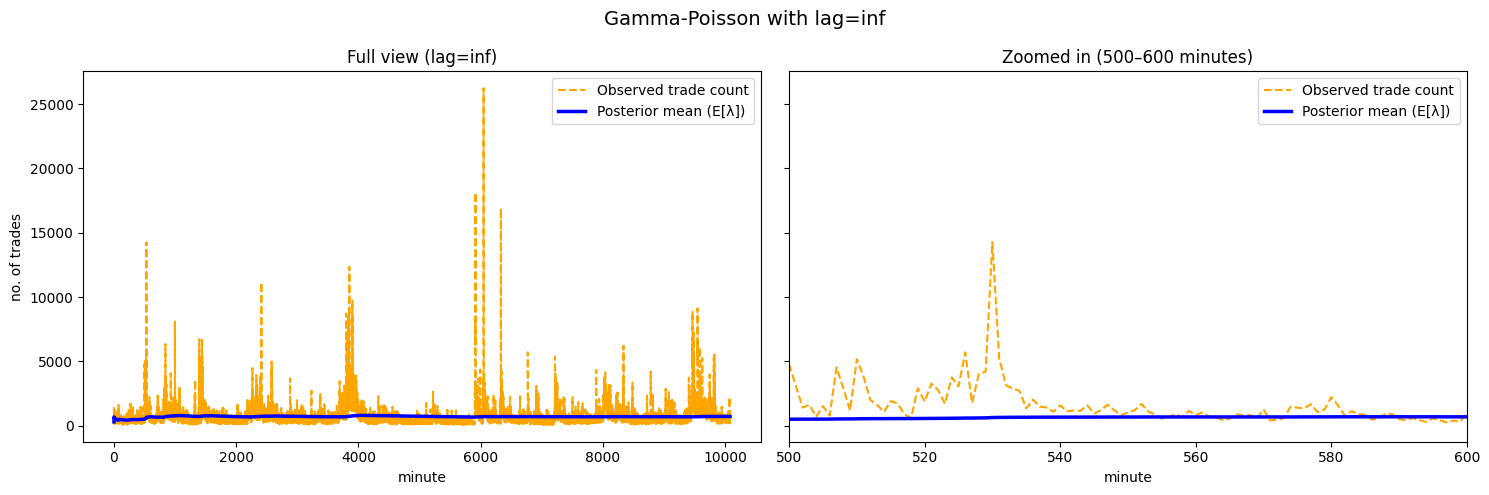

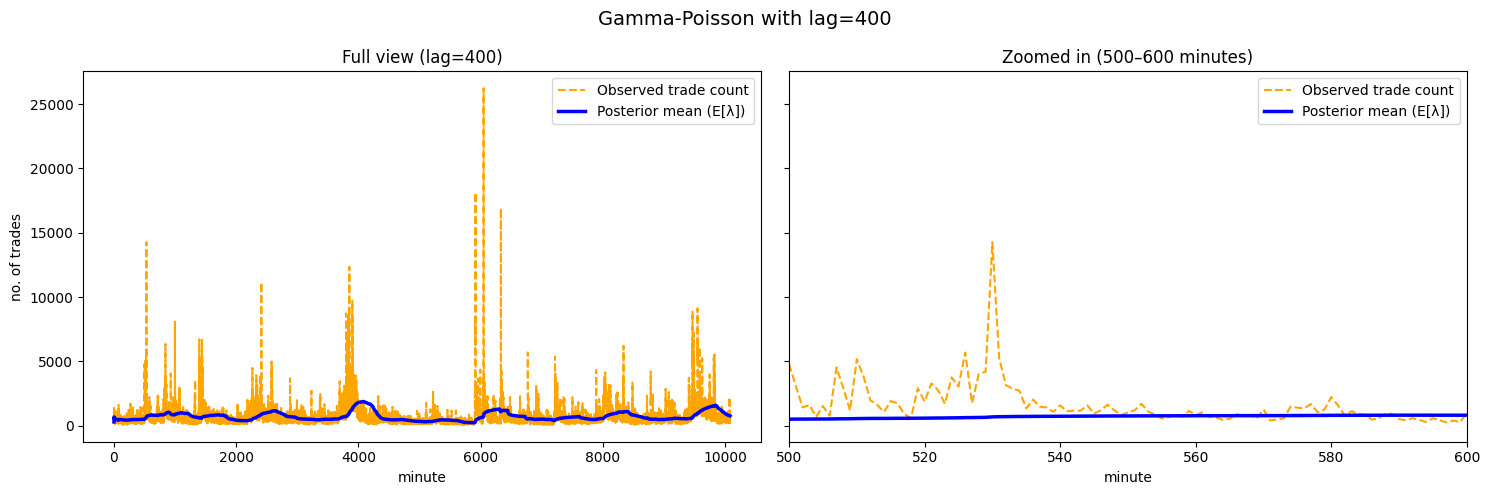

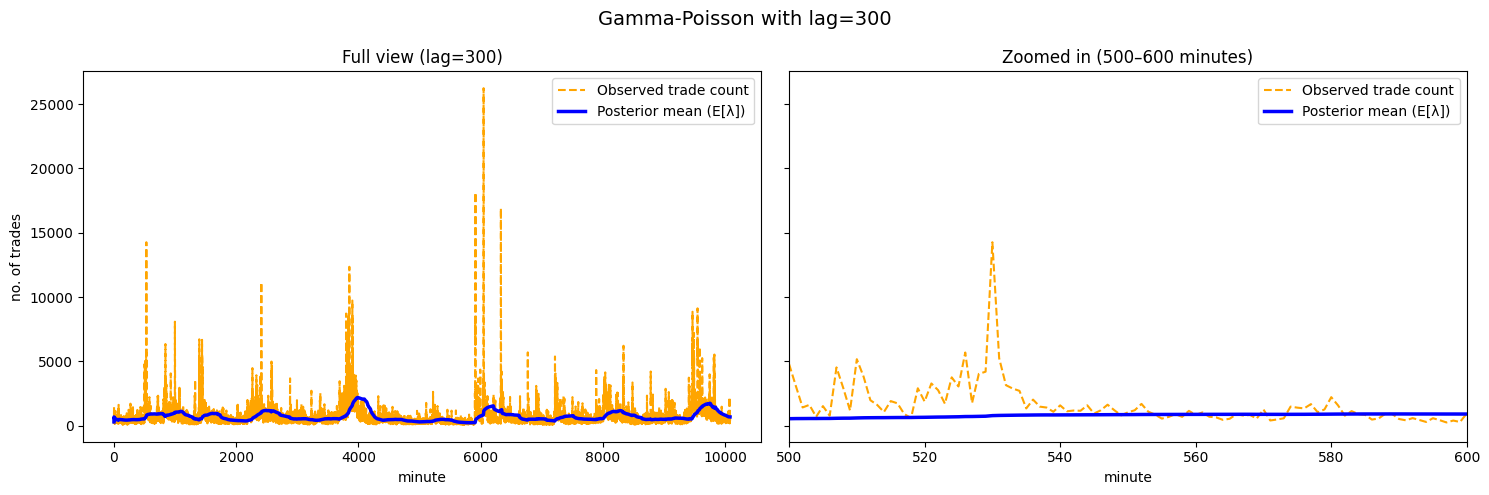

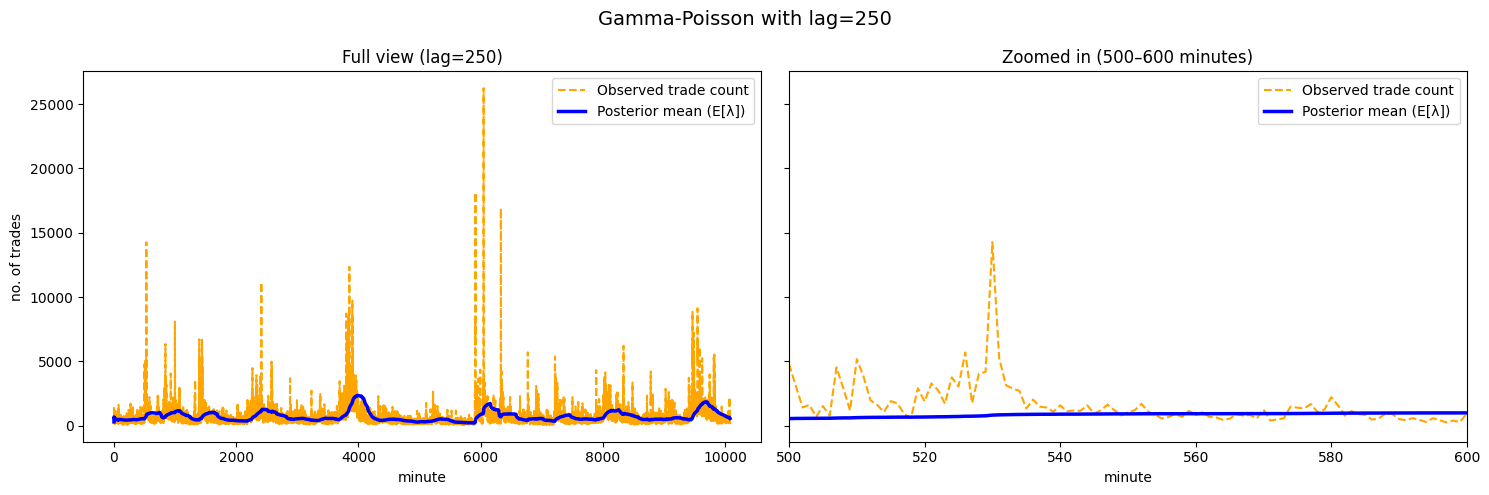

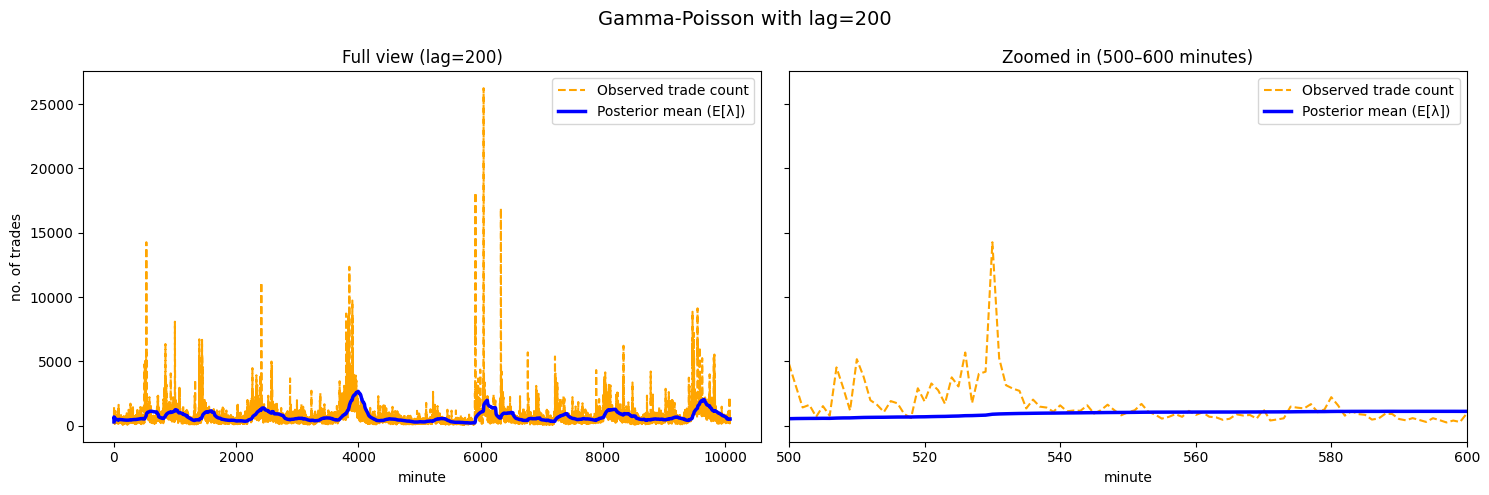

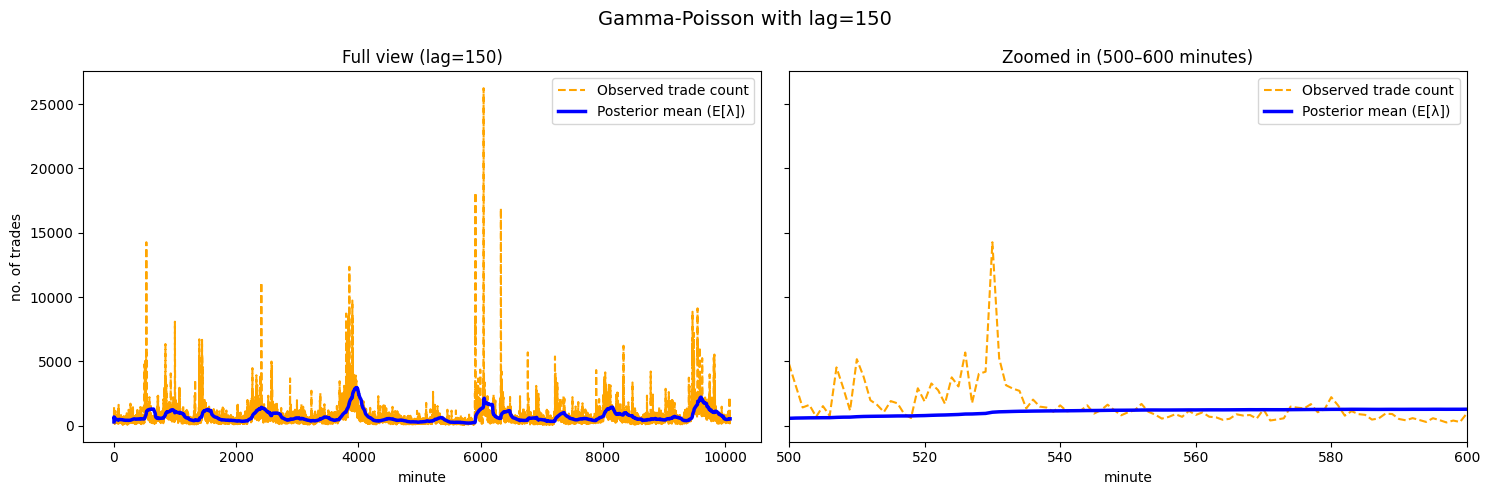

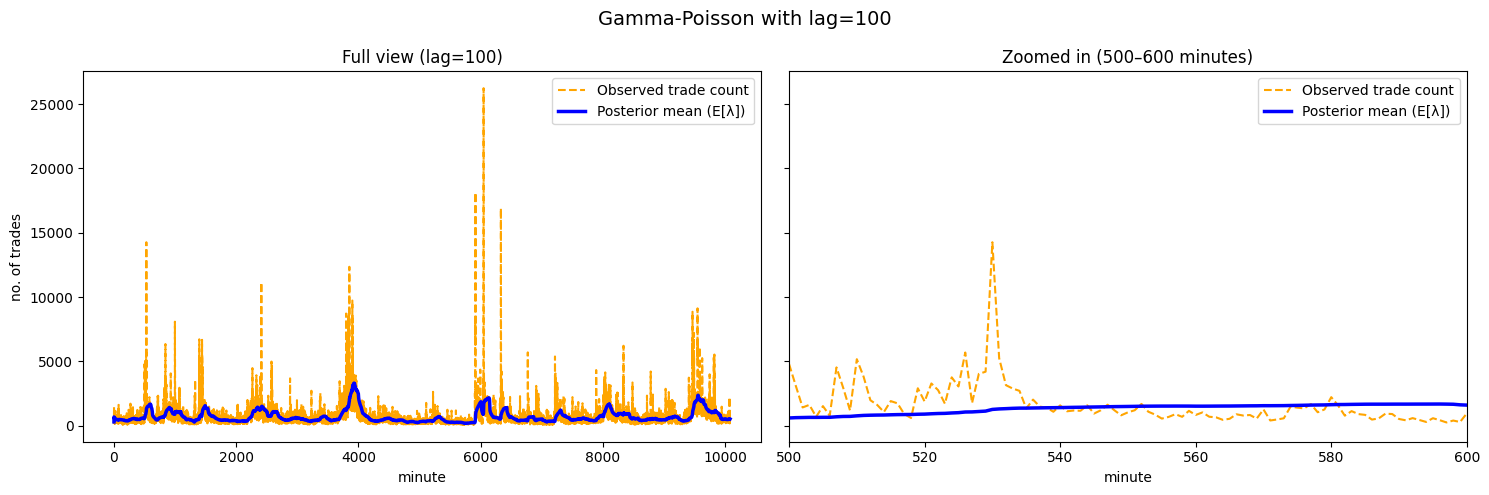

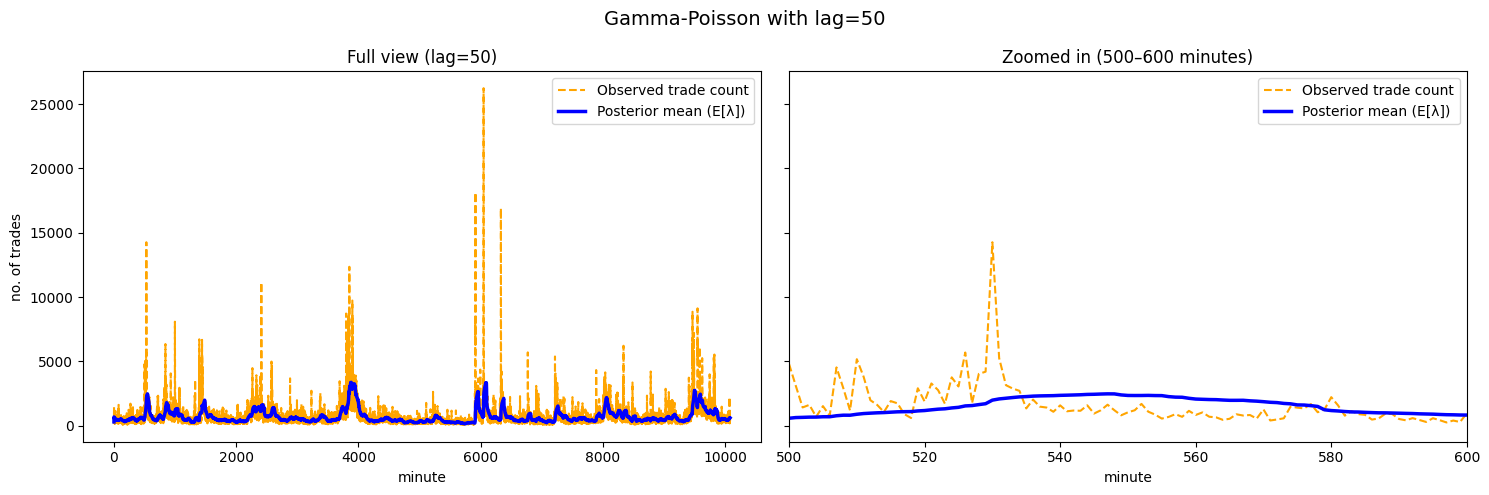

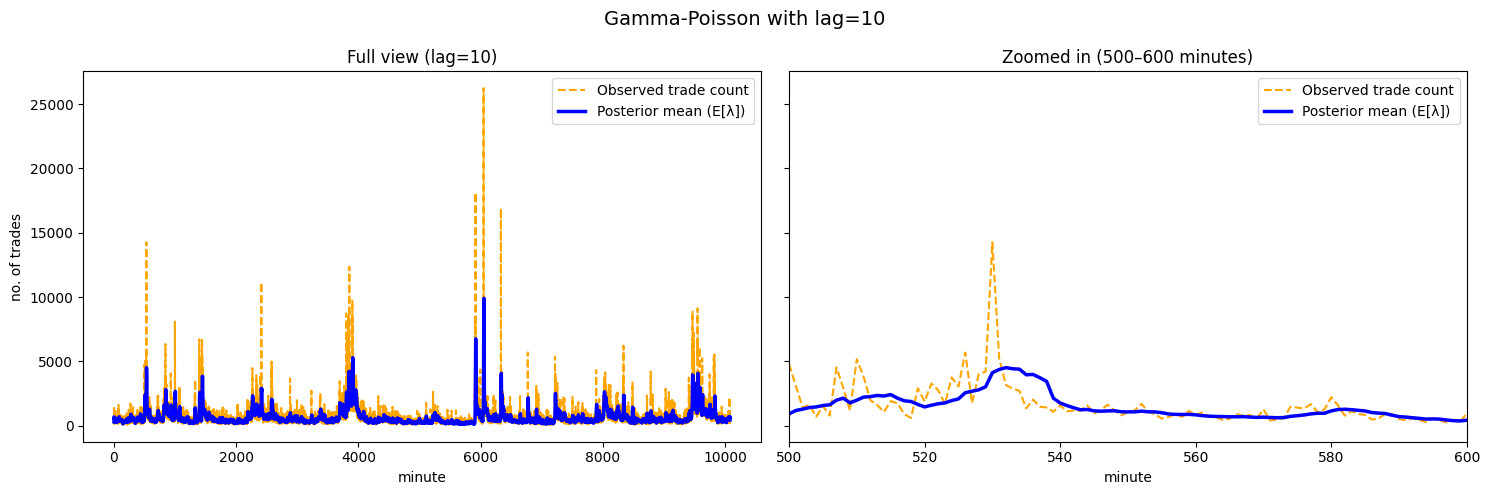

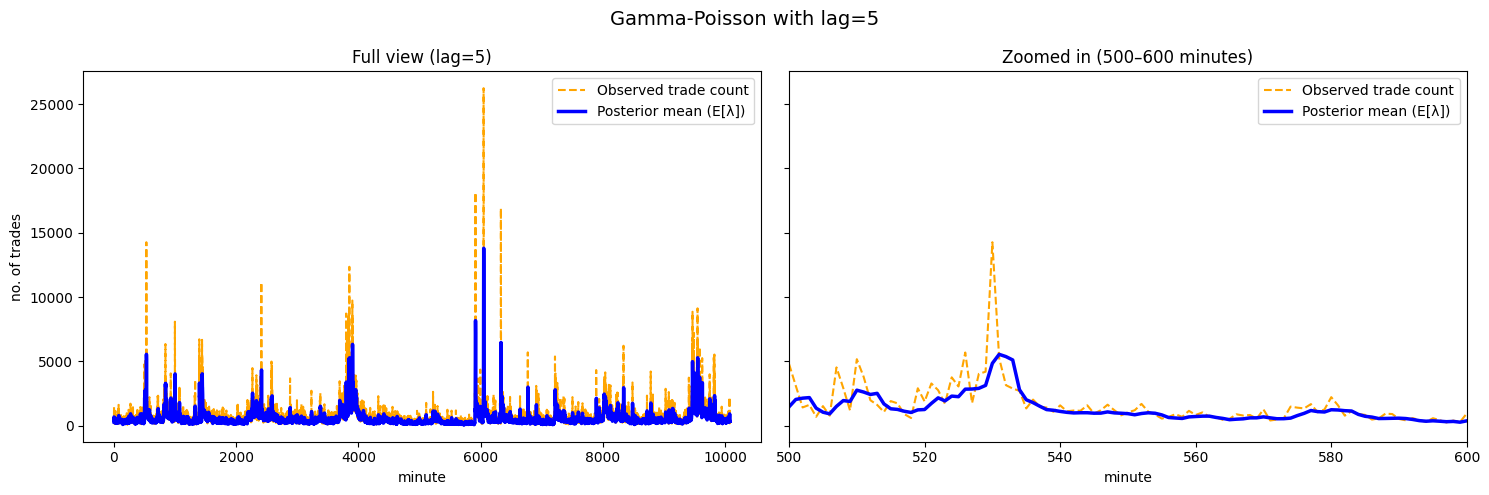

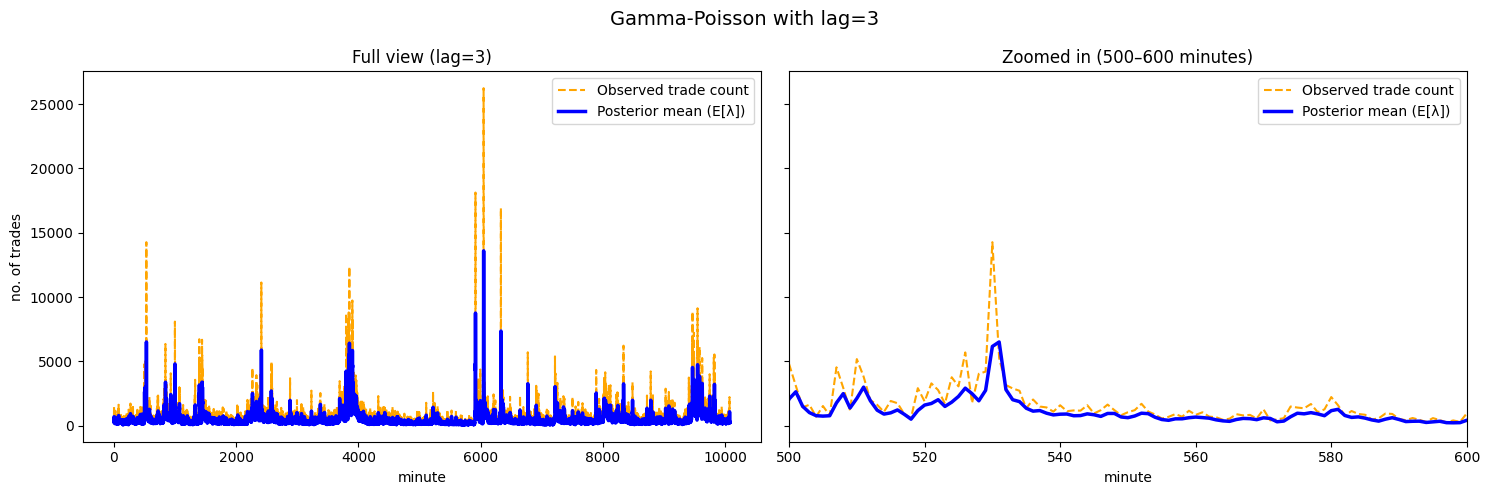

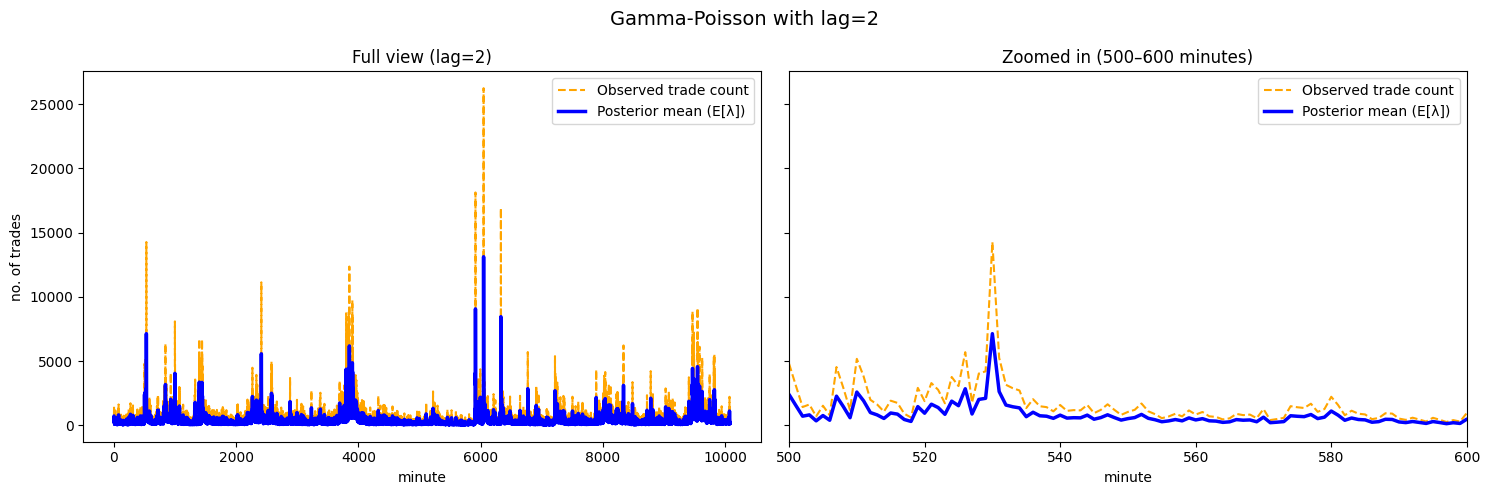

In [5]:
def expected_lambda(params, lag, zoom_start=0, zoom_end=200):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

    lmda = [alpha / beta for alpha, beta in zip(params["alpha"][1:], params["beta"][1:])]
    x = range(len(df["trade_count"].values))

    # --- Left: Full plot ---
    axs[0].plot(df["trade_count"].values, color="orange", linestyle="--", label="Observed trade count")
    axs[0].plot(lmda, color="blue", linewidth=2.5, label="Posterior mean (E[λ])")
    axs[0].set_title(f"Full view (lag={lag})")
    axs[0].set_xlabel("minute")
    axs[0].set_ylabel("no. of trades")
    axs[0].legend()

    # --- Right: Zoomed-in plot ---
    axs[1].plot(df["trade_count"].values, color="orange", linestyle="--", label="Observed trade count")
    axs[1].plot(lmda, color="blue", linewidth=2.5, label="Posterior mean (E[λ])")
    axs[1].set_xlim(zoom_start, zoom_end)
    axs[1].set_title(f"Zoomed in ({zoom_start}–{zoom_end} minutes)")
    axs[1].set_xlabel("minute")
    axs[1].legend()

    plt.suptitle(f"Gamma-Poisson with lag={lag}", fontsize=14)
    plt.tight_layout()
    filename = f"GP_ExpMean_lag_{lag}.png"
    file_path = os.path.join("../figures/", filename)
    plt.savefig(file_path, format='png')
    plt.show()
    
for lag in [float("inf"), 400, 300, 250, 200, 150, 100, 50, 10, 5, 3, 2]:
    gp = Gamma_Poisson(1, 1, lag, df)
    gp.generate_posterior()
    expected_lambda(gp.params, lag, zoom_start=500, zoom_end=600)

# Markov Chain Monte Carlo (MCMC) Simulation

Function to generate a ramdom sample
1. randomly generates $\lambda$ from Gamma Distribution
2. randomly generates no. of trades happening in 1min from Poisson$(\lambda)$

In [6]:
def gen_samples(params, n):

    samples = []
    for j in range(n):
        sample_j = []
        for i in range(1, len(params["alpha"])):
            lambda_i = np.random.gamma(params["alpha"][i], 1/params["beta"][i])
            x = np.random.poisson(lambda_i)
            sample_j.append(x)

        samples.append(sample_j)

    return samples

# Posterior Predictive Check (PPC)

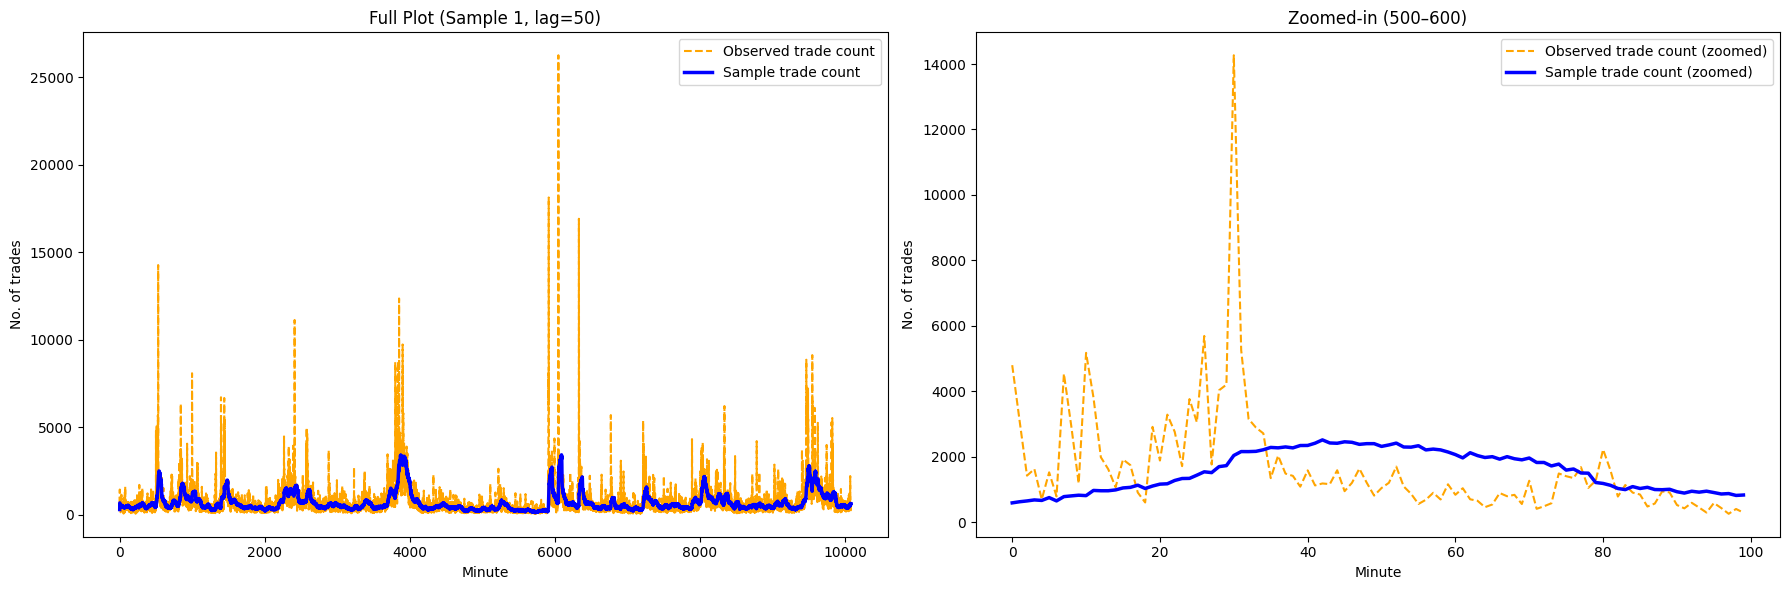

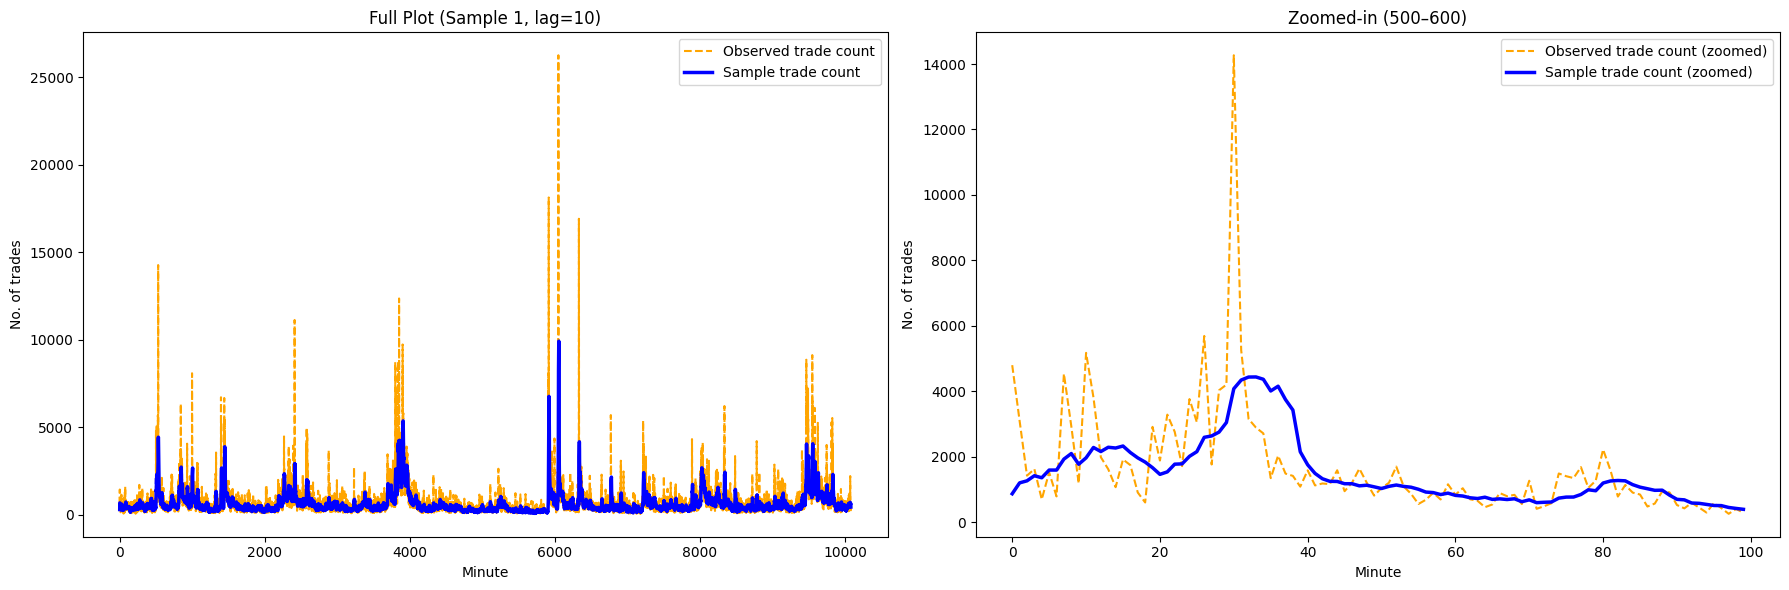

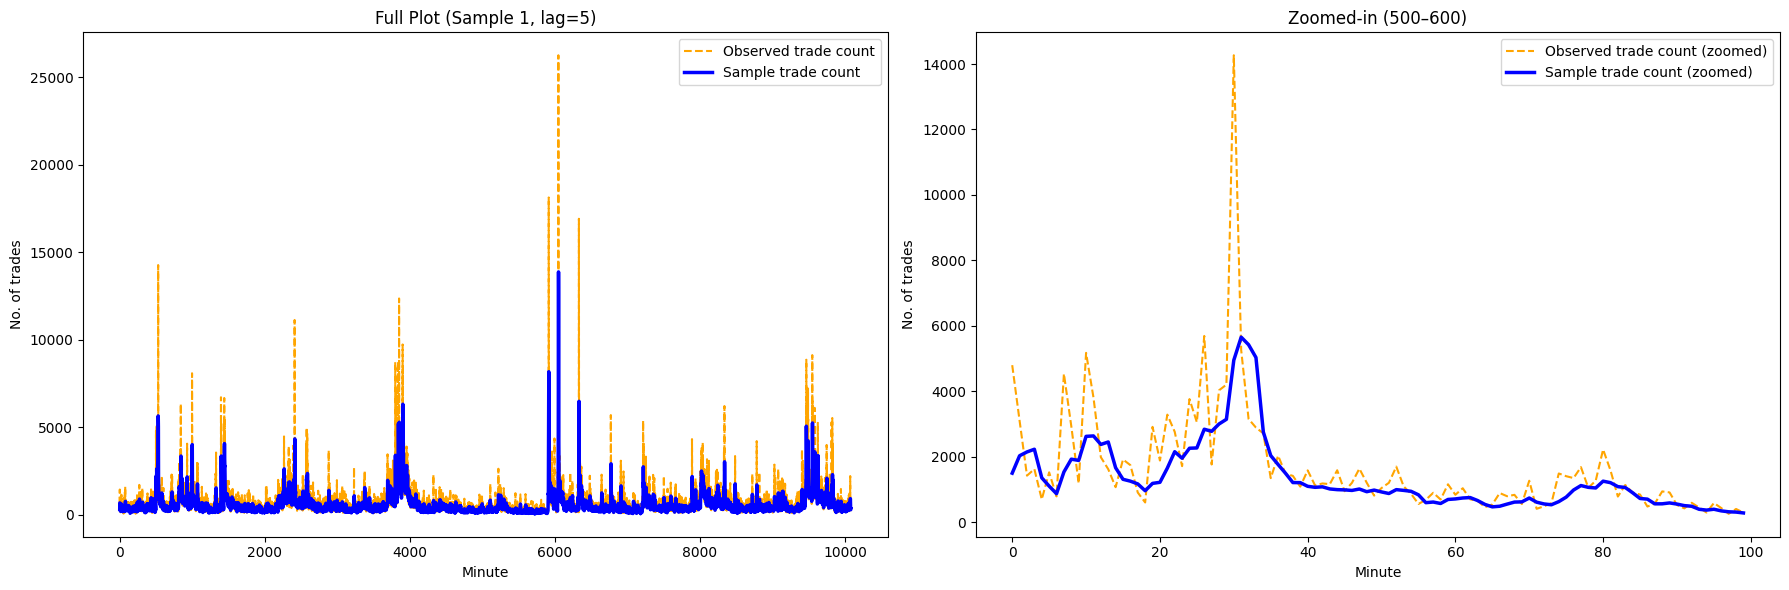

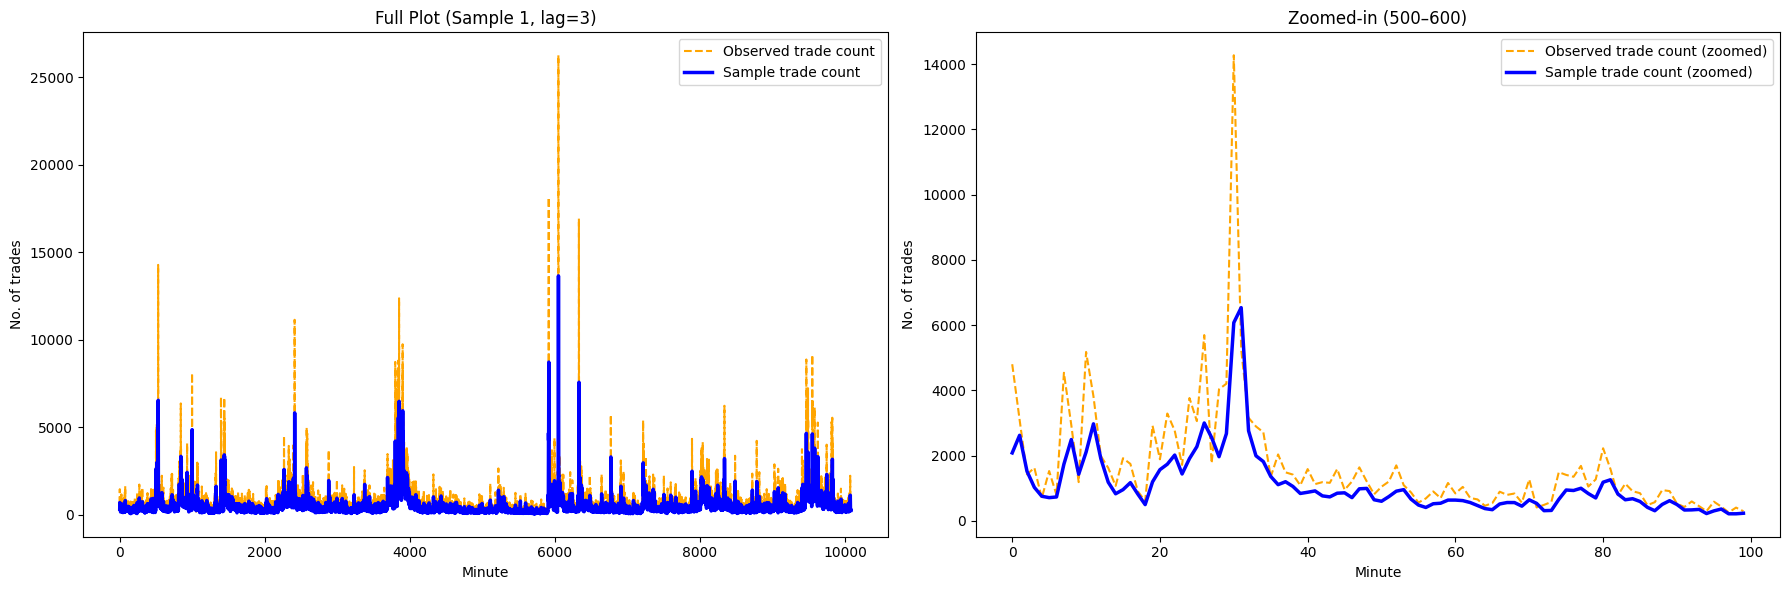

In [7]:
def plot_samples(samples, df, lag, zoom_start=None, zoom_end=None):
    i = 1
    for sample in samples:
        fig, axes = plt.subplots(1, 2, figsize=(18, 6))

        # --- Main Plot ---
        axes[0].plot(df["trade_count"].values, color="orange", linestyle="--", label="Observed trade count")
        axes[0].plot(sample, color="blue", linewidth=2.5, label="Sample trade count")
        axes[0].set_xlabel("Minute")
        axes[0].set_ylabel("No. of trades")
        axes[0].set_title(f"Full Plot (Sample {i}, lag={lag})")
        axes[0].legend()

        # --- Zoomed-in Plot ---
        if zoom_start is not None and zoom_end is not None:
            axes[1].plot(df["trade_count"].values[zoom_start:zoom_end], color="orange", linestyle="--", label="Observed trade count (zoomed)")
            axes[1].plot(sample[zoom_start:zoom_end], color="blue", linewidth=2.5, label="Sample trade count (zoomed)")
            axes[1].set_xlabel("Minute")
            axes[1].set_ylabel("No. of trades")
            axes[1].set_title(f"Zoomed-in ({zoom_start}–{zoom_end})")
            axes[1].legend()
        else:
            axes[1].axis("off")

        plt.tight_layout()
        filename = f"GP_PPC_sample_{i}_lag_{lag}.png"
        file_path = os.path.join("../figures/", filename)
        plt.savefig(file_path, format='png')
        plt.show()
        i += 1


for lag in [50, 10, 5, 3]:
    gp = Gamma_Poisson(1, 1, lag, df)
    gp.generate_posterior()
    np.random.seed(42)
    samples = gen_samples(gp.params, 1)
    plot_samples(samples, df, lag, zoom_start=500, zoom_end = 600)


# Posterior Probability Interval (PPI)

In [8]:
def check_ppi_validity(gp, alpha):
  df = gp.df
  df = df.sort_values(by="timestamp").reset_index(drop=True)
  array = df["trade_count"].tolist()
  cnt = 0
  gp.generate_posterior()
  gp.generate_ppi(alpha)

  for i in range(len(array)):
    if array[i] < gp.ppi[alpha]["lower_bound"][i] or array[i] > gp.ppi[alpha]["upper_bound"][i]:
      cnt += 1
      
  return cnt

table = []
for lag in ([float("inf"), 400, 300, 250, 200, 150, 100, 50, 10, 5, 3, 2]):
    sub = []
    sub.append(lag)
    gp = Gamma_Poisson(1, 1, lag, df)
    gp.generate_posterior()
    val = check_ppi_validity(gp, 0.95)
    sub.append(val)
    sub.append(100 * val / len(gp.df))
    table.append(sub)

html_table = tabulate(table, headers=["Lag", "Count", "Percentage"], tablefmt="html")
display(HTML(html_table))

Lag,Count,Percentage
inf,9369,92.9372
400,9214,91.3997
300,9158,90.8442
250,9137,90.6358
200,9051,89.7828
150,8988,89.1578
100,8966,88.9396
50,8853,87.8187
10,8619,85.4975
5,8513,84.446
